#### **Langgraph Introduction and Prerequisite**

Langgraph is the new framework for the legacy langchain tools & agents. It is the advance way of creating the agents. Agents has the thinking capability means agents has the reasoning capability (brain).

Flow of the agents : 

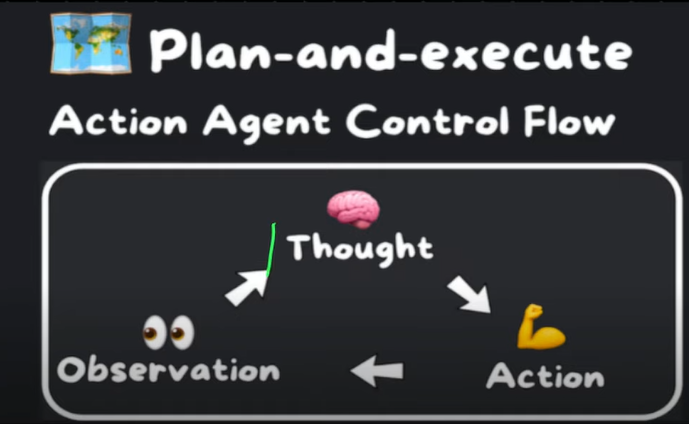

Q. What is the need of agents over chains ?

-> The chains are only run in the single direction, their is no functionality of resoning means their is no functionality checking the final answer.

Question --> think --> tool --> observe --> final_output --> (loop)

In [72]:

# Importing necessary Libraries
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough,RunnableLambda,RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import WikipediaQueryRun,YouTubeSearchTool,TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import tool
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain import hub
from typing import Annotated, List

from dotenv import load_dotenv
load_dotenv()

True

##### **LLMs with Memory**

In [45]:
# testing the llm
llm = ChatGroq(temperature=0)
while True:
    question = input("Ask the question ?")
    if question != "quit":
        print(llm.invoke(question).content)
    else:
        print("goodbye take care of yourself.")
        break

goodbye take care of yourself.


LLMs don't have the concept of conversation memory storage, so we need to handle this at our end using frameworks like llamaindex / langchain

In [4]:
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.messages import AIMessage

We can use this, when we have to create different chats in the application. for each chat we can store the chat_history to refine our responses. 

Just like ChatGPT, where we can add new chat for new questions and previous history is also stored in old chats because of BaseChatMessageHistory()

In [5]:
store = {}
def get_session_history(session_id:str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

In [6]:
config = {"configurable":{"session_id":"firstchat"}}
model_with_memory = RunnableWithMessageHistory(llm,get_session_history)
model_with_memory.invoke(("Hi! I am Hrishikeh"),config=config).content

"Hello Hrishikeh! It's nice to meet you. How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help. 😊"

In [8]:
model_with_memory.invoke(input="What is my name ?",config=config).content

"Based on the information you provided in your first message, your name is Hrishikeh. I'm here to help with any questions or topics you'd like to discuss. If you need assistance with something, just let me know! 😊"

In [9]:
store

{'firstchat': InMemoryChatMessageHistory(messages=[HumanMessage(content='Hi! I am Hrishikeh', additional_kwargs={}, response_metadata={}), AIMessage(content="Hello Hrishikeh! It's nice to meet you. How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help. 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 17, 'total_tokens': 65, 'completion_time': 0.073287259, 'prompt_time': 0.002267782, 'queue_time': 0.029226438000000004, 'total_time': 0.075555041}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-dda692ce-7b98-4852-8a2e-153eac8034cd-0', usage_metadata={'input_tokens': 17, 'output_tokens': 48, 'total_tokens': 65}), HumanMessage(content='What is my name ?', additional_kwargs={}, response_metadata={}), AIMessage(content="You mentioned in your first message that your name is Hrishikeh. Is there a

##### **RAG with LCEL**

In [46]:
# Setting the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [5]:
# Loading the data using the textloader
text_loader = TextLoader(file_path="article.txt")
document = text_loader.load()

# Chunking of the documents 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=30,length_function=len)
documents = text_splitter.split_documents(documents=document)
# doc_string = [document.page_content for document in documents]


# Loading of the embeddings using huggingface
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Initialize the vector database
chromadb = Chroma.from_documents(documents=documents,embedding=embeddings)
retriever = chromadb.as_retriever(search_kwargs={'k':4})

In [6]:
# loading the LLM model
llm = ChatGroq(temperature=0)

In [7]:
# Setting the PromptTemplate
prompt = """
Answer the following questions based on the following context:
{context}

Question : {question}
"""
prompt_template = PromptTemplate.from_template(template=prompt)

In [10]:
# Creating the chain of RAG
retrieval_chain = (
    {"context":retriever, "question":RunnablePassthrough()}
    | prompt_template
    | llm
    | StrOutputParser()
)

In [11]:
response = retrieval_chain.invoke("Evolution of Data Science in 5 points")
print(response)

Based on the provided documents, the evolution of data science can be summarized in the following 5 points:

1. Data Science has its foundation in statistics, which provides the foundational tools and concepts used in data analysis today. (Refer to Document id '08a8c602-465d-441b-baa8-fa51bb793112')

2. The future of data science is expected to involve deeper integration of various areas, enhanced by advancements in technology. (Refer to Document id 'd3e22660-3740-4f5e-818b-98852f872e24')

3. The tools and concepts provided by statistics form the basis of data analysis, which is used to extract insights from data. (Refer to Document id '3fe4d46c-5724-490d-a806-caad13389b42')

4. Generative AI is the latest advancement in data science, focusing on creating new content based on data analysis and insights. (Refer to Document id '3dee68e0-e753-42d8-b98b-e0e45608665d')

5. The evolution of data science is ongoing, with new advancements and integrations continually being developed and resear

##### **Langchain Tools**

Wikipedia tool from langchain

In [29]:
api_wrapper = WikipediaAPIWrapper()
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

print("\n******************** wiki_tool properties *******************")
print("Tool Name : ",wiki_tool.name)
print("Tool Description : ",wiki_tool.description)
print("Tool Args : ",wiki_tool.args)
print("************************************************************** \n")

response = wiki_tool.invoke({"query":"Who is Rohit Sharma"})
print("Response : ",response)


******************** wiki_tool properties *******************
Tool Name :  wikipedia
Tool Description :  A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
Tool Args :  {'query': {'description': 'query to look up on wikipedia', 'title': 'Query', 'type': 'string'}}
************************************************************** 



c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Response :  Page: Rohit Sharma
Summary: Rohit Sharma (born 30 April 1987) is an Indian international cricketer who currently plays for and captains the India national cricket team in Test and ODI matches. He previously captained in T20 matches and in the country's 2024 T20 World Cup win after which he retired from T20s in June. He is considered as one of the best batsmen of his generation and one of the best white-ball opening batters of all time. 
He holds several batting records which famously include most runs in T20 Internationals, most sixes in international cricket, most double centuries in ODI cricket (3), most centuries at Cricket World Cups (7) and joint most hundreds in Twenty20 Internationals (5). He is the first player to score 5 T20I centuries. He also holds the world record for the highest individual score (264) in a One Day International (ODI) match and is the only player to have scored three double-centuries in ODIs and also holds the record for scoring most hundreds (f

Youtube-search tool from langchain

In [37]:
yt_tool = YouTubeSearchTool()
print("\n******************** yt_tool properties *******************")
print("Tool Name : ",yt_tool.name)
print("Tool Description : ",yt_tool.description)
print("Tool Args : ",yt_tool.args)
print("************************************************************** \n")

response = yt_tool.invoke({"query":"BB Ki vines"})
print("Response : ",response)


******************** yt_tool properties *******************
Tool Name :  youtube_search
Tool Description :  search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional
Tool Args :  {'query': {'title': 'Query', 'type': 'string'}}
************************************************************** 

Response :  ['https://www.youtube.com/watch?v=-6fk3PXpznY&pp=ygULQkIgS2kgdmluZXM%3D', 'https://www.youtube.com/watch?v=dFKhWe2bBkM&pp=ygULQkIgS2kgdmluZXM%3D']


Travily search tool

In [50]:
travily_tool = TavilySearchResults()
print("\n******************** travily_tool properties *******************")
print("Tool Name : ",travily_tool.name)
print("Tool Description : ",travily_tool.description)
print("Tool Args : ",travily_tool.args)
print("************************************************************** \n")

response = travily_tool.invoke({"query":"Laus Angelis forest fire news"})
print("Response : ",response[0])


******************** travily_tool properties *******************
Tool Name :  tavily_search_results_json
Tool Description :  A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
Tool Args :  {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}}
************************************************************** 

Response :  {'url': 'https://www.cnn.com/weather/live-news/los-angeles-wildfires-palisades-eaton-california-01-14-25-hnk/index.html', 'content': 'Live updates: Los Angeles wildfires, new blaze in Ventura County, Palisades and Eaton fires | CNN CNN10 About CNN As firefighters work to put out the Palisades, Eaton, and other fires racing through Los Angeles County, flame retardant has been dropped over properties to try and protect them from the blazes. Red flame retardant is seen on a home in the hills of Mandeville Canyon afte

##### **Langchain Custom Tools & Agents**

This **@tool** decorator is the simplest way to define a custom tool. The decorator uses the function name as the tool name by default, but this can be overridden by passing a string as the first argument. Additionally, the decorator will use the function's docstring as the tool's description - so a docstring MUST be provided.

In [52]:
@tool
def get_word_length(sent:str) -> int:
    """ This will return the length of the input string
    Args :
        sent : Input sentence string.
    
    Returns : 
        Integer
    """
    return len(sent)

In [57]:
get_word_length.invoke(input={"sent":"Hrishikesh Dattatray Kothawade"})

30

We can change the schema and other features of the tool

In [59]:
@tool
def multiply_by_max(
    a:Annotated[int,"scale factor"],
    b:Annotated[List[int],"list of ints over which to take maximum"],
) -> int:
    """Multiply a by max of b"""
    return a * max(b)

In [63]:
# Printing the schema of the tool which will contains the tool metadata
multiply_by_max.args_schema.model_json_schema()

{'description': 'Multiply a by max of b',
 'properties': {'a': {'description': 'scale factor',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'list of ints over which to take maximum',
   'items': {'type': 'integer'},
   'title': 'B',
   'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'multiply_by_max',
 'type': 'object'}

We can also customize the json schema and tool name using the tool decorator

In [64]:
@tool("Multiply By Maximum of B list")
def multiply_by_max(
    a:Annotated[int,"scale factor"],
    b:Annotated[List[int],"list of ints over which to take maximum"],
) -> int:
    """Multiply a by max of b"""
    return a * max(b)

In [65]:
# Printing the schema of the tool which will contains the tool metadata
multiply_by_max.args_schema.model_json_schema()

{'description': 'Multiply a by max of b',
 'properties': {'a': {'description': 'scale factor',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'list of ints over which to take maximum',
   'items': {'type': 'integer'},
   'title': 'B',
   'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'Multiply By Maximum of B list',
 'type': 'object'}

**Tool Calling Agent & AgentExecutor**

In [76]:
# Load the LLM model
llm = ChatGroq(temperature=0)

# Load the tools 
travily_tool = TavilySearchResults()
tools = [travily_tool]

# Load the prompt from the langchain hub
prompt = hub.pull("hwchase17/openai-functions-agent")
print(prompt)

# The agent which calls the tools
calling_agent = create_tool_calling_agent(llm,tools,prompt)

# Loading the agent using AgentExecutor
agent_executor = AgentExecutor(agent=calling_agent, tools=tools, verbose=True)

# Getting the response from the tool by giving input
response = agent_executor.invoke(input = {"input":"Weather in Pune, India"})
print(response)


c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['agent_scratchpad', 'input'] optional_variables=['chat_history'] input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')]